# Unrestricted Kohn-Sham 一阶梯度与中间矩阵

这一节我们相对系统地讨论一阶 GGA 梯度的相关性质，包括能量表达式、一阶梯度、U 矩阵的计算与关联；从而对后续的 UKS 的计算打下基础。

## 准备工作

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from matplotlib import pyplot as plt
import numpy as np
from pyscf import gto, scf, dft, grad
from pyscf.scf import ucphf
from functools import partial
from pyxdh.DerivOnce import GradUSCF, GradSCF
from pyxdh.Utilities import GridHelper, KernelHelper
from pyxdh.Utilities import NucCoordDerivGenerator, NumericDiff
import warnings

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=180, suppress=True)
warnings.filterwarnings("ignore")

为了简化计算量，我们大多数时候对格点积分不作非常精细的计算，因此使用非常小的格点 (50, 194)。使用的分子是非对称的 CH3 自由基。

In [2]:
mol = gto.Mole()
mol.atom = """
C  0. 0. 0.
H  1. 0. 0.
H  0. 2. 0.
H  0. 0. 1.5
"""
mol.basis = "6-31G"
mol.spin = 1
mol.verbose = 0
mol.build()
# mol = gto.Mole()
# mol.atom = """
# N  0. 0. 0.
# H  1. 0. 0.
# H  0. 2. 0.
# H  0. 0. 1.5
# """
# mol.basis = "6-31G"
# mol.spin = 0
# mol.verbose = 0
# mol.build()

In [3]:
grids = dft.Grids(mol)
grids.atom_grid = (50, 194)
grids.build()

In [4]:
scf_eng = dft.UKS(mol)
scf_eng.xc = "B3LYPg"
scf_eng.grids = grids
scf_eng.run()
scf_eng.e_tot

-39.60377211830869

In [5]:
gradh = GradUSCF({"scf_eng": scf_eng, "cphf_tol": 1e-10})
gradh.eng

-39.60377211830869

我们顺便定义一下数值导数计算量 `gradn`。可以用它来进行若干矩阵的数值导数计算。

In [6]:
def mol_to_grad_helper(mol):
    g = dft.Grids(mol)
    g.atom_grid = (50, 194)
    g.build()
    mf = dft.UKS(mol)
    mf.xc = "B3LYPg"
    mf.grids = g
    return GradUSCF({"scf_eng": mf.run()})

gradn = NucCoordDerivGenerator(mol, mol_to_grad_helper)

In [7]:
def plot_diff(anal_mat, num_mat):
    fig, ax = plt.subplots(figsize=(2.4, 1.8)); ax.set_xscale("log")
    ax.hist(abs(anal_mat.ravel() - num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    ax.hist(abs(num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    return fig.tight_layout()

## 能量 UKS 计算与相关矩阵

### 新的基础数据结构

由于 Unrestricted 计算会在同一分子中涉及到两套占据轨道信息，因此会产生 RKS 所不会出现的各种不便利，并且要求一种新的数据结构。我们会作简单的说明。

- 对于 GGA 而言，`cx` $c_\mathrm{x}$ 与 `xc` 泛函名称与 RKS 情形相同

In [8]:
cx, xc = gradh.cx, gradh.xc
cx, xc

(0.2, 'B3LYPg')

- `nmo` $n_\mathrm{MO}$、`nao` $n_\mathrm{AO}$、`natm` $n_\mathrm{Atom}$ 与 RKS 的情形相同

In [9]:
nmo, nao, natm = gradh.nmo, gradh.nao, gradh.natm
nmo, nao, natm

(15, 15, 4)

- `nocc` $(n_\mathrm{occ}^\alpha, n_\mathrm{occ}^\beta)$, `nvir` $(n_\mathrm{vir}^\alpha, n_\mathrm{vir}^\beta)$ 则是 `Tuple[int]` 类型

In [10]:
nocc, nvir = gradh.nocc, gradh.nvir
nocc, nvir

((5, 4), (10, 11))

- `so`, `sv`, `sa` 作为占据、非占、全轨道的分割，其类型也变为了 `Tuple[slice]` 类型

In [11]:
so, sv, sa = gradh.so, gradh.sv, gradh.sa
so, sv, sa

((slice(0, 5, None), slice(0, 4, None)),
 (slice(5, 15, None), slice(4, 15, None)),
 (slice(0, 15, None), slice(0, 15, None)))

- `C` $C_{\mu p}^\sigma$, `e` $e_p^\sigma$ 分别是轨道系数与轨道能，维度分别是 $(\sigma, \mu, p)$ 与 $(\sigma, p)$

- 一般来说，$\sigma$ 在 np.einsum 程序中会用 `x`, `y` 等表示

- $\sigma$ 在以后的程序中，通常置于维度的第一位置，比被求导量 $\mathbb{A}$ 优先

- 由于 `C[0]` $C_{\mu p}^\alpha$ 与 `C[1]` $C_{\mu p}^\beta$ 维度相同，因此 `C` 使用 `np.ndarray` 储存；`e` 同理

In [12]:
C, e = gradh.C, gradh.e
C.shape, e.shape

((2, 15, 15), (2, 15))

- `Co` $C_{\mu i}^\sigma$ 为占据轨道系数，维度是 $(\sigma, \mu, i)$

- 但是留意，由于 $\alpha$ 与 $\beta$ 自旋的占据轨道数不同，因此使用 `Tuple[np.ndarray]` 储存；以后的矩阵通常也按照这两种方式分别处理

In [13]:
Co = gradh.Co
Co[0].shape, Co[1].shape

((15, 5), (15, 4))

- `eo` $e_i^\sigma$ 为占据轨道能，维度 $(\sigma, i)$，类型同理 `Tuple[np.ndarray]`

In [14]:
eo = gradh.eo
eo[0].shape, eo[1].shape

((5,), (4,))

上述的情况也可以用于定义非占轨道系数与非占轨道能：

In [15]:
Cv, ev = gradh.Cv, gradh.ev

- `mo_occ` $\delta_{p \in \mathrm{occ}}^\sigma$ 表示轨道占据情况

In [16]:
mo_occ = gradh.mo_occ
mo_occ

array([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### 电子积分

- `H_0_ao` $h_{\mu \nu}$, `S_0_ao` $S_{\mu \nu}$, `eri0_ao` $(\mu \nu | \kappa \lambda)$, `H_1_ao` $h_{\mu \nu}^\mathbb{A}$, `S_1_ao` $S_{\mu \nu}^\mathbb{A}$, `eri1_ao` $(\mu \nu | \kappa \lambda)^\mathbb{A}$ 与 RKS 没有区别

In [17]:
H_0_ao, S_0_ao, eri0_ao, H_1_ao, S_1_ao, eri1_ao = gradh.H_0_ao, gradh.S_0_ao, gradh.eri0_ao, gradh.H_1_ao, gradh.S_1_ao, gradh.eri1_ao

- `H_0_mo` $h_{pq}^\sigma$, `S_0_mo` $S_{pq}^\sigma$, dim: $(\sigma, p, q)$, type: `np.ndarray`

- `H_1_mo` $h_{pq}^{\mathbb{A}, \sigma}$, `S_1_mo` $S_{\mu \nu}^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, p, q)$, type: `np.ndarray`

In [18]:
H_0_mo, S_0_mo = gradh.H_0_mo, gradh.S_0_mo
H_0_mo.shape, S_0_mo.shape

((2, 15, 15), (2, 15, 15))

In [19]:
H_1_mo, S_1_mo = gradh.H_1_mo, gradh.S_1_mo
H_1_mo.shape, S_1_mo.shape

((2, 12, 15, 15), (2, 12, 15, 15))

以 `H_1_mo` $h_{pq}^{\mathbb{A}, \sigma}$ 为例，

$$
h_{pq}^{\mathbb{A}, \sigma} = h_{\mu \nu}^\mathbb{A} C_{\mu p}^\sigma C_{\nu q}^\sigma
$$

In [20]:
np.allclose(np.einsum("Auv, xup, xvq -> xApq", H_1_ao, C, C), H_1_mo)

True

- `eri0_mo` $(pq|rs)^{\sigma \sigma'}$, dim: $(\sigma \sigma', p, q, r, s)$, type: `np.ndarray`

- 上述的 $\sigma \sigma'$ 所实际指代的是 $\alpha \alpha, \alpha \beta, \beta \beta$；$(pq|rs)^{\sigma \sigma'}$ 中，$p, q$ 是 $\sigma$ 自旋的，而 $r, s$ 是 $\sigma'$ 自旋的

$$
(pq|rs)^{\sigma \sigma'} = (\mu \nu | \kappa \lambda) C_{\mu p}^\sigma C_{\nu q}^\sigma C_{\kappa r}^{\sigma'} C_{\lambda s}^{\sigma'}
$$

In [21]:
eri0_mo = gradh.eri0_mo
eri0_mo.shape

(3, 15, 15, 15, 15)

In [22]:
np.allclose(
    np.array([
        np.einsum("uvkl, up, vq, kr, ls -> pqrs", eri0_ao, C[0], C[0], C[0], C[0]),
        np.einsum("uvkl, up, vq, kr, ls -> pqrs", eri0_ao, C[0], C[0], C[1], C[1]),
        np.einsum("uvkl, up, vq, kr, ls -> pqrs", eri0_ao, C[1], C[1], C[1], C[1]),
    ]),
    eri0_mo
)

True

- `eri1_mo` $(pq|rs)^{\mathbb{A}, \sigma \sigma'}$, dim: $(\sigma \sigma', \mathbb{A}, p, q, r, s)$, type: `np.ndarray`，与 `eri0_mo` $(pq|rs)^{\sigma \sigma'}$ 同理

In [23]:
eri1_mo = gradh.eri1_mo
eri1_mo.shape

(3, 12, 15, 15, 15, 15)

### 密度矩阵 $D_{\mu \nu}^\sigma$

- `D` $D_{\mu \nu}^\sigma$, dim: $(\sigma, \mu, \nu)$, type: `np.ndarray`

$$
D_{\mu \nu}^\sigma = C_{\mu p}^\sigma C_{\nu p}^\sigma \delta_{p \in \mathrm{occ}}^\sigma
$$

In [24]:
D = gradh.D
D.shape

(2, 15, 15)

In [25]:
np.allclose(np.einsum("xup, xvp, xp -> xuv", C, C, mo_occ), D)

True

另一种验证方式是

$$
D_{\mu \nu}^\sigma = C_{\mu i}^\sigma C_{\nu i}^\sigma
$$

但需要留意到，两种自旋的占据轨道数量并不相同；因此，不能像上面一行代码即可验证。

In [26]:
(
    np.allclose(np.einsum("ui, vi -> uv", Co[0], Co[0]), D[0]),
    np.allclose(np.einsum("ui, vi -> uv", Co[1], Co[1]), D[1])
)

(True, True)

### 库伦积分 $J_{\mu \nu}$ 与交换积分 $K_{\mu \nu}$

该积分尽管常用，但以后不经常用该记号。通常以后会显式地写出如何从原子轨道与密度作张量缩并。

该积分的定义与 RKS 相同。如果我们定义影响库伦积分的密度矩阵为 $X_{\kappa \lambda}$，那么

- $J_{\mu \nu} = (\mu \nu | \kappa \lambda) X_{\kappa \lambda}$

- $K_{\mu \nu} = (\mu \kappa | \nu \lambda) X_{\kappa \lambda}$

In [27]:
X = np.random.randn(nao, nao)

In [28]:
np.allclose(np.einsum("uvkl, kl -> uv", eri0_ao, X), scf_eng.get_j(dm=X))

True

In [29]:
np.allclose(np.einsum("ukvl, kl -> uv", eri0_ao, X), scf_eng.get_k(dm=X, hermi=0))

True

### 轨道与密度格点、泛函核格点

- 轨道与密度格点仍然用 `grdh` 记号表示，但在文档中，会使用 `Tuple[GridHelper]` 类型储存，长度为 2。两个 `GridHelper` 类型分别代表 $\alpha, \beta$ 密度下的轨道与密度格点。在 pyxdh 程序中，使用 `zip[GridIterator]`。

In [30]:
grdh = (GridHelper(mol, grids, D[0]), GridHelper(mol, grids, D[1]))

In [31]:
ngrid = grdh[0].ngrid
ngrid

26836

- 泛函核格点仍然用 `kerh` 记号表示

In [32]:
kerh = KernelHelper(grdh, xc, deriv=3)

但由于使用了带自旋密度，因此许多量与 RKS 稍有不同。简单的情况中，在 RKS 中为向量的 $f_\rho$ 在这里变成两条向量 $(f_{\rho^\alpha}, f_{\rho^\beta})$。

In [33]:
kerh.fr

array([[-0.     , -0.     , -0.     , ..., -0.01168, -0.01275, -0.01399],
       [-0.     , -0.     , -0.     , ..., -0.01172, -0.01275, -0.014  ]])

而 $f_{\gamma}$ 则分为了 $(f_{\gamma^{\alpha \alpha}}, f_{\gamma^{\alpha \beta}}, f_{\gamma^{\beta \beta}})$。

In [34]:
kerh.fg

array([[-0.     , -0.     , -0.     , ..., -0.36551, -0.46675, -0.43452],
       [ 0.     ,  0.     ,  0.     , ...,  0.21322,  0.34198,  0.32137],
       [-0.     , -0.     , -0.     , ..., -0.36812, -0.43788, -0.4247 ]])

我们下面系统地整理一下 PySCF 中对泛函核导数的 [说明](http://pyscf.org/pyscf/dft.html#pyscf.dft.libxc.eval_xc):

- `exc` $f$ 与 RKS 较为接近

In [35]:
kerh.exc.shape

(26836,)

- `fr` 2: `u, d`

    - $f_{\rho^\alpha}, f_{\rho^\beta}$

- `fg` 3: `uu, ud, dd`

    - $f_{\gamma^{\alpha \alpha}}, f_{\gamma^{\alpha \beta}}, f_{\gamma^{\beta \beta}}$

In [36]:
kerh.fr.shape[0], kerh.fg.shape[0]

(2, 3)

- `frr` 3: `u_u, u_d, d_d`

    - $f_{\rho^\alpha \rho^\alpha}, f_{\rho^\alpha \rho^\beta}, f_{\rho^\beta \rho^\beta}$

- `frg` 6: `u_uu, u_ud, u_dd, d_uu, d_ud, d_dd`

    - $f_{\rho^\alpha \gamma^{\alpha \alpha}}, f_{\rho^\alpha \gamma^{\alpha \beta}}, f_{\rho^\alpha \gamma^{\beta \beta}}, f_{\rho^\beta \gamma^{\alpha \alpha}}, f_{\rho^\beta \gamma^{\alpha \beta}}, f_{\rho^\beta \gamma^{\beta \beta}}$

- `fgg` 6: `uu_uu, uu_ud, uu_dd, ud_ud, ud_dd, dd_dd`

    - $f_{\gamma^{\alpha \alpha} \gamma^{\alpha \alpha}}, f_{\gamma^{\alpha \alpha} \gamma^{\alpha \beta}}, f_{\gamma^{\alpha \alpha} \gamma^{\beta \beta}}, f_{\gamma^{\alpha \beta} \gamma^{\alpha \beta}}, f_{\gamma^{\alpha \beta} \gamma^{\beta \beta}}, f_{\gamma^{\beta \beta} \gamma^{\beta \beta}}$

In [37]:
kerh.frr.shape[0], kerh.frg.shape[0], kerh.fgg.shape[0]

(3, 6, 6)

- `frrr` 4: `u_u_u, u_u_d, u_d_d, d_d_d`

    - $f_{\rho^\alpha \rho^\alpha \rho^\alpha}, f_{\rho^\alpha \rho^\alpha \rho^\beta}, f_{\rho^\alpha \rho^\beta \rho^\beta}, f_{\rho^\beta \rho^\beta \rho^\beta}$

- `frrg` 9: `u_u_uu, u_u_ud, u_u_dd, u_d_uu, u_d_ud, u_d_dd, d_d_uu, d_d_ud, d_d_dd`

    - $f_{\rho^\alpha \rho^\alpha \gamma^{\alpha \alpha}}, f_{\rho^\alpha \rho^\alpha \gamma^{\alpha \beta}}, f_{\rho^\alpha \rho^\alpha \gamma^{\beta \beta}}, f_{\rho^\alpha \rho^\beta \gamma^{\alpha \alpha}}, f_{\rho^\alpha \rho^\beta \gamma^{\alpha \beta}}, f_{\rho^\alpha \rho^\beta \gamma^{\beta \beta}}, f_{\rho^\beta \rho^\beta \gamma^{\alpha \alpha}}, f_{\rho^\beta \rho^\beta \gamma^{\alpha \beta}}, f_{\rho^\beta \rho^\beta \gamma^{\beta \beta}}$

- `frgg` 12: `u_uu_uu, u_uu_ud, u_uu_dd, u_ud_ud, u_ud_dd, u_dd_dd, d_uu_uu, d_uu_ud, d_uu_dd, d_ud_ud, d_ud_dd, d_dd_dd`

    - $f_{\rho^\alpha \gamma^{\alpha \alpha} \gamma^{\alpha \alpha}}, f_{\rho^\alpha \gamma^{\alpha \alpha} \gamma^{\alpha \beta}}, f_{\rho^\alpha \gamma^{\alpha \alpha} \gamma^{\beta \beta}}, f_{\rho^\alpha \gamma^{\alpha \beta} \gamma^{\alpha \beta}}, f_{\rho^\alpha \gamma^{\alpha \beta} \gamma^{\beta \beta}}, f_{\rho^\alpha \gamma^{\beta \beta} \gamma^{\beta \beta}}, f_{\rho^\beta \gamma^{\alpha \alpha} \gamma^{\alpha \alpha}}, f_{\rho^\beta \gamma^{\alpha \alpha} \gamma^{\alpha \beta}}, f_{\rho^\beta \gamma^{\alpha \alpha} \gamma^{\beta \beta}}, f_{\rho^\beta \gamma^{\alpha \beta} \gamma^{\alpha \beta}}, f_{\rho^\beta \gamma^{\alpha \beta} \gamma^{\beta \beta}}, f_{\rho^\beta \gamma^{\beta \beta} \gamma^{\beta \beta}}$

- `fggg` 10: `uu_uu_uu, uu_uu_ud, uu_uu_dd, uu_ud_ud, uu_ud_dd, uu_dd_dd, ud_ud_ud, ud_ud_dd, ud_dd_dd, dd_dd_dd`

    - $f_{\gamma^{\alpha \alpha} \gamma^{\alpha \alpha} \gamma^{\alpha \alpha}}, f_{\gamma^{\alpha \alpha} \gamma^{\alpha \alpha} \gamma^{\alpha \beta}}, f_{\gamma^{\alpha \alpha} \gamma^{\alpha \alpha} \gamma^{\beta \beta}}, f_{\gamma^{\alpha \alpha} \gamma^{\alpha \beta} \gamma^{\alpha \beta}}, f_{\gamma^{\alpha \alpha} \gamma^{\alpha \beta} \gamma^{\beta \beta}}, f_{\gamma^{\alpha \alpha} \gamma^{\beta \beta} \gamma^{\beta \beta}}, f_{\gamma^{\alpha \beta} \gamma^{\alpha \beta} \gamma^{\alpha \beta}}, f_{\gamma^{\alpha \beta} \gamma^{\alpha \beta} \gamma^{\beta \beta}}, f_{\gamma^{\alpha \beta} \gamma^{\beta \beta} \gamma^{\beta \beta}}, f_{\gamma^{\beta \beta} \gamma^{\beta \beta} \gamma^{\beta \beta}}$

In [38]:
kerh.frrr.shape[0], kerh.frrg.shape[0], kerh.frgg.shape[0], kerh.fggg.shape[0]

(4, 9, 12, 10)

### 能量计算

$$
E_\mathrm{elec} = h_{\mu \nu} D_{\mu \nu}^\sigma + \frac{1}{2} (\mu \nu | \kappa \lambda) D_{\mu \nu}^\sigma D_{\kappa \lambda}^{\sigma'} - \frac{c_\mathrm{x}}{2} (\mu \kappa | \nu \lambda) D_{\mu \nu}^\sigma D_{\kappa \lambda}^\sigma + f \rho^\sigma
$$

In [39]:
(
    + np.einsum("uv, xuv -> ", H_0_ao, D)
    + 0.5 * np.einsum("uvkl, xuv, ykl -> ", eri0_ao, D, D)
    - 0.5 * cx * np.einsum("ukvl, xuv, xkl -> ", eri0_ao, D, D)
    + np.einsum("g, g -> ", kerh.exc, grdh[0].rho_0)
    + np.einsum("g, g -> ", kerh.exc, grdh[1].rho_0)
)

-47.22493668809642

In [40]:
scf_eng.energy_elec()[0]

-47.22493669052412

### Fock 矩阵

- `F_0_ao` $F_{\mu \nu}^\sigma$, dim: $(\sigma, \mu, \nu)$, type: `np.ndarray`

$$
F_{\mu \nu}^\sigma \xleftarrow{\textsf{HF contrib}} h_{\mu \nu} + (\mu \nu | \kappa \lambda) D_{\kappa \lambda}^{\sigma'} - c_\mathrm{x} (\mu \kappa | \nu \lambda) D_{\kappa \lambda}^\sigma
$$

$$
F_{\mu \nu}^\alpha \xleftarrow{\textsf{GGA contrib}} f_{\rho^\alpha} \phi_\mu \phi_\nu + \big[ (2 f_{\gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\gamma^{\alpha \beta}} \rho_r^{\beta}) \phi_{r \mu} \phi_\nu + \mathrm{swap} (\mu, \nu) \big]
$$

需要注意，不像其他电子积分的原子轨道矩阵一样，Fock 矩阵是有自旋之分的。生成 Fock 矩阵的过程稍复杂，因此我们需要将 HF 贡献部分先计算，随后计算 GGA 贡献部分，最后加和。

In [41]:
F_0_ao = gradh.F_0_ao
F_0_ao.shape

(2, 15, 15)

In [42]:
F_0_ao_ = (
    + H_0_ao
    + np.einsum("uvkl, ykl -> uv", eri0_ao, D)
    - cx * np.einsum("ukvl, xkl -> xuv", eri0_ao, D)
)

In [43]:
F_0_ao_GGA_ = np.zeros_like(F_0_ao_)
F_0_ao_GGA_[0] = (
    + 2 * np.einsum("g, rg, rgu, gv -> uv", kerh.fg[0], grdh[0].rho_1, grdh[0].ao_1, grdh[0].ao_0)
    + np.einsum("g, rg, rgu, gv -> uv", kerh.fg[1], grdh[1].rho_1, grdh[0].ao_1, grdh[0].ao_0)
)
F_0_ao_GGA_[1] = (
    + 2 * np.einsum("g, rg, rgu, gv -> uv", kerh.fg[2], grdh[1].rho_1, grdh[0].ao_1, grdh[0].ao_0)
    + np.einsum("g, rg, rgu, gv -> uv", kerh.fg[1], grdh[0].rho_1, grdh[0].ao_1, grdh[0].ao_0)
)
F_0_ao_GGA_ += F_0_ao_GGA_.swapaxes(-1, -2)
F_0_ao_GGA_ += np.einsum("xg, gu, gv -> xuv", kerh.fr, grdh[0].ao_0, grdh[0].ao_0)

In [44]:
F_0_ao_ += F_0_ao_GGA_

In [45]:
np.allclose(F_0_ao_, F_0_ao)

True

- `F_0_ao` $F_{pq}^\sigma$, dim: $(\sigma, p, q)$, type: `np.ndarray`

$$
F_{pq}^\sigma = F_{\mu \nu}^\sigma C_{\mu p}^\sigma C_{\nu q}^\sigma
$$

In [46]:
F_0_mo = gradh.F_0_mo
F_0_mo.shape

(2, 15, 15)

In [47]:
np.allclose(np.einsum("xuv, xup, xvq -> xpq", F_0_ao, C, C), F_0_mo)

True

## 一阶 Skeleton 导数

### 一阶核坐标梯度

$$
E_\mathrm{tot}^\mathbb{A} \xleftarrow{\textsf{HF/nuc contrib}} h_{\mu \nu}^\mathbb{A} D_{\mu \nu}^\sigma + \frac{1}{2} (\mu \nu | \kappa \lambda)^\mathbb{A} D_{\mu \nu}^\sigma D_{\kappa \lambda}^{\sigma'} - \frac{c_\mathrm{x}}{2} (\mu \kappa | \nu \lambda)^\mathbb{A} D_{\mu \nu}^\sigma D_{\kappa \lambda}^{\sigma} - S_{i}^{\mathbb{A}, \sigma} \varepsilon_{i}^\sigma + E_\mathrm{nuc}^\mathbb{A}
$$

$$
E_\mathrm{tot}^\mathbb{A} \xleftarrow{\textsf{GGA contrib}} f_{\rho^\alpha} \rho^{\mathbb{A}, \alpha} + 2 f_{\gamma^{\alpha \alpha}} \rho_r^{\alpha} \rho_r^{\mathbb{A}, \alpha} + f_{\gamma^{\alpha \beta}} \rho_r^{\beta} \rho_r^{\mathbb{A}, \beta} + \mathrm{swap} (\alpha, \beta)
$$

In [48]:
E_1 = gradh.E_1
E_1

array([[ 0.06565, -0.08058, -0.11324],
       [-0.0919 ,  0.01814,  0.02577],
       [ 0.00907,  0.05126,  0.00839],
       [ 0.01718,  0.01118,  0.07909]])

In [49]:
E_1_ = (
    + np.einsum("Auv, xuv -> A", H_1_ao, D)
    + 0.5 * np.einsum("Auvkl, yuv, xkl -> A", eri1_ao, D, D)
    - 0.5 * cx * np.einsum("Aukvl, xuv, xkl -> A", eri1_ao, D, D)
    # - np.einsum("xApq, xpq, xp, xq -> A", S_1_mo, F_0_mo, mo_occ, mo_occ)
    - np.einsum("Ai, i -> A", S_1_mo[0, :, so[0], so[0]].diagonal(axis1=-1, axis2=-2), eo[0])
    - np.einsum("Ai, i -> A", S_1_mo[1, :, so[1], so[1]].diagonal(axis1=-1, axis2=-2), eo[1])
    + grad.rhf.grad_nuc(mol).reshape(-1)
).reshape((natm, 3))

In [50]:
E_1_ += (
    + np.einsum("g, Atg -> At", kerh.fr[0], grdh[0].A_rho_1)
    + np.einsum("g, Atg -> At", kerh.fr[1], grdh[1].A_rho_1)
    + 2 * np.einsum("g, rg, Atrg -> At", kerh.fg[0], grdh[0].rho_1, grdh[0].A_rho_2)
    + 2 * np.einsum("g, rg, Atrg -> At", kerh.fg[2], grdh[1].rho_1, grdh[1].A_rho_2)
    + 1 * np.einsum("g, rg, Atrg -> At", kerh.fg[1], grdh[1].rho_1, grdh[0].A_rho_2)
    + 1 * np.einsum("g, rg, Atrg -> At", kerh.fg[1], grdh[0].rho_1, grdh[1].A_rho_2)
)

In [51]:
E_1

array([[ 0.06565, -0.08058, -0.11324],
       [-0.0919 ,  0.01814,  0.02577],
       [ 0.00907,  0.05126,  0.00839],
       [ 0.01718,  0.01118,  0.07909]])

### Fock Skeleton 一阶导数：HF 部分

- `F_1_ao` $F_{\mu \nu}^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, \mu, \nu)$, type: `np.ndarray`

In [52]:
F_1_ao = gradh.F_1_ao
F_1_ao.shape

(2, 12, 15, 15)

该式的推导方式比 RKS 的情形要复杂很多。我们首先需要定义变量

- `A_gamma_1` $\gamma^{\mathbb{A}, \sigma \sigma'}$, dim: $(\sigma \sigma', A, t, g)$, type: `np.ndarray`

$$
\gamma^{\mathbb{A}, \sigma \sigma'} = \rho_r^{\mathbb{A}, \sigma} \rho_r^{\sigma'} + \rho_r^{\mathbb{A}, \sigma'} \rho_r^{\sigma}
$$

In [53]:
A_gamma_1 = np.zeros((3, natm, 3, grdh[0].ngrid))
A_gamma_1[0] = 2 * np.einsum("Atrg, rg -> Atg", grdh[0].A_rho_2, grdh[0].rho_1)
A_gamma_1[1] = (
    + np.einsum("Atrg, rg -> Atg", grdh[0].A_rho_2, grdh[1].rho_1)
    + np.einsum("Atrg, rg -> Atg", grdh[1].A_rho_2, grdh[0].rho_1)
)
A_gamma_1[2] = 2 * np.einsum("Atrg, rg -> Atg", grdh[1].A_rho_2, grdh[1].rho_1)

我们之后生成的 Fock 矩阵的 Skeleton 导数会放在变量 `F_1_ao_` 中 (后面加上下划线以示区别)。HF 部分的贡献相当容易给出：

$$
F_{\mu \nu}^{\mathbb{A}, \sigma} \xleftarrow{\textsf{HF contrib}} h_{\mu \nu}^\mathbb{A} + (\mu \nu | \kappa \lambda)^\mathbb{A} D_{\kappa \lambda}^{\sigma'} - c_\mathrm{x} (\mu \kappa | \nu \lambda)^\mathbb{A} D_{\kappa \lambda}^\sigma
$$

In [54]:
F_1_ao_ = (
    + H_1_ao
    + np.einsum("Auvkl, ykl -> Auv", eri1_ao, D)
    - cx * np.einsum("Aukvl, xkl -> xAuv", eri1_ao, D)
)

### Fock Skeleton 一阶导数：GGA $\alpha$ 自旋部分

GGA 部分的贡献会很复杂。我们先回顾一下 GGA 对 Fock 矩阵的贡献方式：

$$
F_{\mu \nu}^\alpha \xleftarrow{\textsf{GGA contrib}} f_{\rho^\alpha} \phi_\mu \phi_\nu + \big[ (2 f_{\gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\gamma^{\alpha \beta}} \rho_r^{\beta}) \phi_{r \mu} \phi_\nu + \mathrm{swap} (\mu, \nu) \big]
$$

我们按照下述方式给出 Skeleton 导数。

- 0：$f_{\rho^\alpha}$ 的所有 Skeleton 导数贡献

- 1：$f_{\gamma^{\alpha \beta}}$ 关于 $\rho^\sigma$ 的所有偏导部分的 Skeleton 导数贡献

- 2：$f_{\gamma^{\alpha \beta}}$ 关于 $\gamma^{\sigma \sigma'}$ 的所有偏导部分的 Skeleton 导数贡献

- 3：上式中出现的 $\rho_r^\sigma$ 的 Skeleton 导数贡献

- 4：上式中出现的原子轨道格点的 Skeleton 导数贡献

$$
F_{\mu \nu}^{\mathbb{A}, \alpha} \xleftarrow{\textsf{GGA contrib 0}} 
\left[
f_{\rho^\alpha \rho^\alpha} \rho^{\mathbb{A}, \alpha}
+ f_{\rho^\alpha \rho^\beta} \rho^{\mathbb{A}, \beta}
+ f_{\rho^\alpha \gamma^{\alpha \alpha}} \gamma^{\mathbb{A}, \alpha \alpha}
+ f_{\rho^\alpha \gamma^{\alpha \beta}} \gamma^{\mathbb{A}, \alpha \beta}
+ f_{\rho^\alpha \gamma^{\beta \beta}} \gamma^{\mathbb{A}, \beta \beta}
\right] \phi_\mu \phi_\nu
$$

$$
F_{\mu \nu}^{\mathbb{A}, \alpha} \xleftarrow{\textsf{GGA contrib 1}}
\big[
(2 f_{\rho^\alpha \gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\rho^\alpha \gamma^{\alpha \beta}} \rho_r^{\beta}) \rho^{\mathbb{A}, \alpha}
+ (2 f_{\rho^\beta \gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\rho^\beta \gamma^{\alpha \beta}} \rho_r^{\beta}) \rho^{\mathbb{A}, \beta}
\big] \phi_{r \mu} \phi_\nu
+ \mathrm{swap} (\mu, \nu)
$$

$$
F_{\mu \nu}^{\mathbb{A}, \alpha} \xleftarrow{\textsf{GGA contrib 2}}
\big[
(2 f_{\gamma^{\alpha \alpha} \gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\gamma^{\alpha \beta} \gamma^{\alpha \alpha}} \rho_r^\beta)  \gamma^{\mathbb{A}, \alpha \alpha}
+ (2 f_{\gamma^{\alpha \alpha} \gamma^{\alpha \beta}} \rho_r^\alpha + f_{\gamma^{\alpha \beta} \gamma^{\alpha \beta}} \rho_r^\beta)  \gamma^{\mathbb{A}, \alpha \beta}
+ (2 f_{\gamma^{\alpha \alpha} \gamma^{\beta \beta}} \rho_r^\alpha + f_{\gamma^{\alpha \beta} \gamma^{\beta \beta}} \rho_r^\beta) \gamma^{\mathbb{A}, \beta \beta}
\big] \phi_{r \mu} \phi_\nu
+ \mathrm{swap} (\mu, \nu)
$$

$$
F_{\mu \nu}^{\mathbb{A}, \alpha} \xleftarrow{\textsf{GGA contrib 3}}
\big[
2 f_{\gamma^{\alpha \alpha}} \rho_r^{\mathbb{A}, \alpha} + f_{\gamma^{\alpha \beta}} \rho_r^{\mathbb{A}, \beta}
\big] \phi_{r \mu} \phi_\nu
+ \mathrm{swap} (\mu, \nu)
$$

$$
F_{\mu \nu}^{A_t, \alpha} \xleftarrow{\textsf{GGA contrib 4}}
- \big[
f_{\rho^\alpha} \phi_{t \mu_A} \phi_\nu
+ (2 f_{\gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\gamma^{\alpha \beta}} \rho_r^{\beta}) (\phi_{tr \mu_A} \phi_\nu + \phi_{t \mu_A} \phi_{r \nu})
\big] + \mathrm{swap} (\mu, \nu)
$$

由于两种自旋所取用泛函核不同，因此 $\alpha, \beta$ 两种自旋对 Fock 矩阵 Skeleton 导数的贡献代码应当要分开写。我们将所有 $\alpha$ 自旋下，GGA 的所有贡献写到 `F_1_ao_GGA_alpha_` 中。

- `F_1_ao_GGA_alpha_`, type: `List[np.ndarray]`; for each element in list, dim: $(A, t, \mu, \nu)$

    - 之所以每个列表元素的维度不是 $(\mathbb{A}, \mu, \nu)$，单纯地是因为在 `GridHelper` 中的所有格点导数均采用 $(A, t)$ 即 $(n_\mathrm{Atom}, 3)$ 的维度大小的形式，而不是使用 pyxdh 项目中通常会用的 $(\mathbb{A}, )$ 即 $(n_\mathrm{Atom} \times 3, )$ 的形式。

In [55]:
F_1_ao_GGA_alpha_ = [None for _ in range(5)]

$$
F_{\mu \nu}^{\mathbb{A}, \alpha} \xleftarrow{\textsf{GGA contrib 0}} 
\left[
f_{\rho^\alpha \rho^\alpha} \rho^{\mathbb{A}, \alpha}
+ f_{\rho^\alpha \rho^\beta} \rho^{\mathbb{A}, \beta}
+ f_{\rho^\alpha \gamma^{\alpha \alpha}} \gamma^{\mathbb{A}, \alpha \alpha}
+ f_{\rho^\alpha \gamma^{\alpha \beta}} \gamma^{\mathbb{A}, \alpha \beta}
+ f_{\rho^\alpha \gamma^{\beta \beta}} \gamma^{\mathbb{A}, \beta \beta}
\right] \phi_\mu \phi_\nu
$$

In [56]:
tmp = (
    + kerh.frr[0] * grdh[0].A_rho_1 + kerh.frr[1] * grdh[1].A_rho_1
    + kerh.frg[0] * A_gamma_1[0] + kerh.frg[1] * A_gamma_1[1] + kerh.frg[2] * A_gamma_1[2]
)
F_1_ao_GGA_alpha_[0] = np.einsum("Atg, gu, gv -> Atuv", tmp, grdh[0].ao_0, grdh[0].ao_0)

$$
F_{\mu \nu}^{\mathbb{A}, \alpha} \xleftarrow{\textsf{GGA contrib 1}}
\big[
(2 f_{\rho^\alpha \gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\rho^\alpha \gamma^{\alpha \beta}} \rho_r^{\beta}) \rho^{\mathbb{A}, \alpha}
+ (2 f_{\rho^\beta \gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\rho^\beta \gamma^{\alpha \beta}} \rho_r^{\beta}) \rho^{\mathbb{A}, \beta}
\big] \phi_{r \mu} \phi_\nu
+ \mathrm{swap} (\mu, \nu)
$$

In [57]:
tmp = (
    + np.einsum("rg, Atg -> Atrg", 2 * kerh.frg[0] * grdh[0].rho_1 + kerh.frg[1] * grdh[1].rho_1, grdh[0].A_rho_1)
    + np.einsum("rg, Atg -> Atrg", 2 * kerh.frg[3] * grdh[0].rho_1 + kerh.frg[4] * grdh[1].rho_1, grdh[1].A_rho_1)
)
F_1_ao_GGA_alpha_[1] = np.einsum("Atrg, rgu, gv -> Atuv", tmp, grdh[0].ao_1, grdh[0].ao_0)
F_1_ao_GGA_alpha_[1] += F_1_ao_GGA_alpha_[1].swapaxes(-1, -2)

$$
F_{\mu \nu}^{\mathbb{A}, \alpha} \xleftarrow{\textsf{GGA contrib 2}}
\big[
(2 f_{\gamma^{\alpha \alpha} \gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\gamma^{\alpha \beta} \gamma^{\alpha \alpha}} \rho_r^\beta)  \gamma^{\mathbb{A}, \alpha \alpha}
+ (2 f_{\gamma^{\alpha \alpha} \gamma^{\alpha \beta}} \rho_r^\alpha + f_{\gamma^{\alpha \beta} \gamma^{\alpha \beta}} \rho_r^\beta)  \gamma^{\mathbb{A}, \alpha \beta}
+ (2 f_{\gamma^{\alpha \alpha} \gamma^{\beta \beta}} \rho_r^\alpha + f_{\gamma^{\alpha \beta} \gamma^{\beta \beta}} \rho_r^\beta) \gamma^{\mathbb{A}, \beta \beta}
\big] \phi_{r \mu} \phi_\nu
+ \mathrm{swap} (\mu, \nu)
$$

In [58]:
tmp = (
    + np.einsum("rg, Atg -> Atrg", 2 * kerh.fgg[0] * grdh[0].rho_1 + kerh.fgg[1] * grdh[1].rho_1, A_gamma_1[0])
    + np.einsum("rg, Atg -> Atrg", 2 * kerh.fgg[1] * grdh[0].rho_1 + kerh.fgg[3] * grdh[1].rho_1, A_gamma_1[1])
    + np.einsum("rg, Atg -> Atrg", 2 * kerh.fgg[2] * grdh[0].rho_1 + kerh.fgg[4] * grdh[1].rho_1, A_gamma_1[2])
)
F_1_ao_GGA_alpha_[2] = np.einsum("Atrg, rgu, gv -> Atuv", tmp, grdh[0].ao_1, grdh[0].ao_0)
F_1_ao_GGA_alpha_[2] += F_1_ao_GGA_alpha_[2].swapaxes(-1, -2)

$$
F_{\mu \nu}^{\mathbb{A}, \alpha} \xleftarrow{\textsf{GGA contrib 4}}
\big[
2 f_{\gamma^{\alpha \alpha}} \rho_r^{\mathbb{A}, \alpha} + f_{\gamma^{\alpha \beta}} \rho_r^{\mathbb{A}, \beta}
\big] \phi_{r \mu} \phi_\nu
+ \mathrm{swap} (\mu, \nu)
$$

In [59]:
tmp = 2 * kerh.fg[0] * grdh[0].A_rho_2 + kerh.fg[1] * grdh[1].A_rho_2
F_1_ao_GGA_alpha_[3] = np.einsum("Atrg, rgu, gv -> Atuv", tmp, grdh[0].ao_1, grdh[0].ao_0)
F_1_ao_GGA_alpha_[3] += F_1_ao_GGA_alpha_[3].swapaxes(-1, -2)

$$
F_{\mu \nu}^{A_t, \alpha} \xleftarrow{\textsf{GGA contrib 5}}
- \big[
f_{\rho^\alpha} \phi_{t \mu_A} \phi_\nu
+ (2 f_{\gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\gamma^{\alpha \beta}} \rho_r^{\beta}) (\phi_{tr \mu_A} \phi_\nu + \phi_{t \mu_A} \phi_{r \nu})
\big] + \mathrm{swap} (\mu, \nu)
$$

In [60]:
mol_slice = gradh.mol_slice

In [61]:
tmp = 2 * kerh.fg[0] * grdh[0].rho_1 + kerh.fg[1] * grdh[1].rho_1

F_1_ao_GGA_alpha_[4] = np.zeros((natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    F_1_ao_GGA_alpha_[4][A, :, sA, :] += - np.einsum("g, tgu, gv -> tuv", kerh.fr[0], grdh[0].ao_1[:, :, sA], grdh[0].ao_0)
    F_1_ao_GGA_alpha_[4][A, :, sA, :] += - np.einsum("rg, trgu, gv -> tuv", tmp, grdh[0].ao_2[:, :, :, sA], grdh[0].ao_0)
    F_1_ao_GGA_alpha_[4][A, :, sA, :] += - np.einsum("rg, tgu, rgv -> tuv", tmp, grdh[0].ao_1[:, :, sA], grdh[0].ao_1)
F_1_ao_GGA_alpha_[4] += F_1_ao_GGA_alpha_[4].swapaxes(-1, -2)

最后，我们将 $\alpha$ 自旋的 GGA 贡献部分加到 HF 贡献部分，得到最终的 $F_{\mu \nu}^{\mathbb{A}, \alpha}$。 

In [62]:
F_1_ao_[0] += np.array(F_1_ao_GGA_alpha_).sum(axis=0).reshape((natm * 3, nao, nao))

In [63]:
np.allclose(F_1_ao_[0], F_1_ao[0])

True

### Fock Skeleton 一阶导数：GGA $\beta$ 自旋部分

但需要留意，我们尚没有实现 $\beta$ 自旋的贡献部分。尽管思路是相同的，但代码应当要重新写一遍。

In [64]:
F_1_ao_GGA_beta_ = [None for _ in range(5)]

$$
F_{\mu \nu}^{\mathbb{A}, \beta} \xleftarrow{\textsf{GGA contrib 0}} 
\left[
f_{\rho^\beta \rho^\alpha} \rho^{\mathbb{A}, \alpha}
+ f_{\rho^\beta \rho^\beta} \rho^{\mathbb{A}, \beta}
+ f_{\rho^\beta \gamma^{\alpha \alpha}} \gamma^{\mathbb{A}, \alpha \alpha}
+ f_{\rho^\beta \gamma^{\beta \alpha}} \gamma^{\mathbb{A}, \beta \alpha}
+ f_{\rho^\beta \gamma^{\beta \beta}} \gamma^{\mathbb{A}, \beta \beta}
\right] \phi_\mu \phi_\nu
$$

In [65]:
tmp = (
    + kerh.frr[1] * grdh[0].A_rho_1 + kerh.frr[2] * grdh[1].A_rho_1
    + kerh.frg[3] * A_gamma_1[0] + kerh.frg[4] * A_gamma_1[1] + kerh.frg[5] * A_gamma_1[2]
)
F_1_ao_GGA_beta_[0] = np.einsum("Atg, gu, gv -> Atuv", tmp, grdh[0].ao_0, grdh[0].ao_0)

$$
F_{\mu \nu}^{\mathbb{A}, \beta} \xleftarrow{\textsf{GGA contrib 1}}
\big[
(2 f_{\rho^\alpha \gamma^{\beta \beta}} \rho_r^\beta + f_{\rho^\alpha \gamma^{\beta \alpha}} \rho_r^{\alpha}) \rho^{\mathbb{A}, \alpha}
+ (2 f_{\rho^\beta \gamma^{\beta \beta}} \rho_r^\beta + f_{\rho^\beta \gamma^{\beta \alpha}} \rho_r^{\alpha}) \rho^{\mathbb{A}, \beta}
\big] \phi_{r \mu} \phi_\nu
+ \mathrm{swap} (\mu, \nu)
$$

In [66]:
tmp = (
    + np.einsum("rg, Atg -> Atrg", 2 * kerh.frg[2] * grdh[1].rho_1 + kerh.frg[1] * grdh[0].rho_1, grdh[0].A_rho_1)
    + np.einsum("rg, Atg -> Atrg", 2 * kerh.frg[5] * grdh[1].rho_1 + kerh.frg[4] * grdh[0].rho_1, grdh[1].A_rho_1)
)
F_1_ao_GGA_beta_[1] = np.einsum("Atrg, rgu, gv -> Atuv", tmp, grdh[0].ao_1, grdh[0].ao_0)
F_1_ao_GGA_beta_[1] += F_1_ao_GGA_beta_[1].swapaxes(-1, -2)

$$
F_{\mu \nu}^{\mathbb{A}, \beta} \xleftarrow{\textsf{GGA contrib 2}}
\big[
(2 f_{\gamma^{\beta \beta} \gamma^{\alpha \alpha}} \rho_r^\beta + f_{\gamma^{\beta \alpha} \gamma^{\alpha \alpha}} \rho_r^\alpha) \gamma^{\mathbb{A}, \alpha \alpha}
+ (2 f_{\gamma^{\beta \beta} \gamma^{\beta \alpha}} \rho_r^\beta + f_{\gamma^{\beta \alpha} \gamma^{\beta \alpha}} \rho_r^\alpha)  \gamma^{\mathbb{A}, \beta \alpha}
+ (2 f_{\gamma^{\beta \beta} \gamma^{\beta \beta}} \rho_r^\beta + f_{\gamma^{\beta \alpha} \gamma^{\beta \beta}} \rho_r^\alpha)  \gamma^{\mathbb{A}, \beta \beta}
\big] \phi_{r \mu} \phi_\nu
+ \mathrm{swap} (\mu, \nu)
$$

In [67]:
tmp = (
    + np.einsum("rg, Atg -> Atrg", 2 * kerh.fgg[2] * grdh[1].rho_1 + kerh.fgg[1] * grdh[0].rho_1, A_gamma_1[0])
    + np.einsum("rg, Atg -> Atrg", 2 * kerh.fgg[4] * grdh[1].rho_1 + kerh.fgg[3] * grdh[0].rho_1, A_gamma_1[1])
    + np.einsum("rg, Atg -> Atrg", 2 * kerh.fgg[5] * grdh[1].rho_1 + kerh.fgg[4] * grdh[0].rho_1, A_gamma_1[2])
)
F_1_ao_GGA_beta_[2] = np.einsum("Atrg, rgu, gv -> Atuv", tmp, grdh[0].ao_1, grdh[0].ao_0)
F_1_ao_GGA_beta_[2] += F_1_ao_GGA_beta_[2].swapaxes(-1, -2)

$$
F_{\mu \nu}^{\mathbb{A}, \beta} \xleftarrow{\textsf{GGA contrib 4}}
\big[
2 f_{\gamma^{\beta \beta}} \rho_r^{\mathbb{A}, \beta} + f_{\gamma^{\beta \alpha}} \rho_r^{\mathbb{A}, \alpha}
\big] \phi_{r \mu} \phi_\nu
+ \mathrm{swap} (\mu, \nu)
$$

In [68]:
tmp = 2 * kerh.fg[2] * grdh[1].A_rho_2 + kerh.fg[1] * grdh[0].A_rho_2
F_1_ao_GGA_beta_[3] = np.einsum("Atrg, rgu, gv -> Atuv", tmp, grdh[0].ao_1, grdh[0].ao_0)
F_1_ao_GGA_beta_[3] += F_1_ao_GGA_beta_[3].swapaxes(-1, -2)

$$
F_{\mu \nu}^{A_t, \beta} \xleftarrow{\textsf{GGA contrib 5}}
- \big[
f_{\rho^\beta} \phi_{t \mu_A} \phi_\nu
+ (2 f_{\gamma^{\beta \beta}} \rho_r^\beta + f_{\gamma^{\beta \alpha}} \rho_r^{\alpha}) (\phi_{tr \mu_A} \phi_\nu + \phi_{t \mu_A} \phi_{r \nu})
\big] + \mathrm{swap} (\mu, \nu)
$$

In [69]:
mol_slice = gradh.mol_slice

In [70]:
tmp = 2 * kerh.fg[2] * grdh[1].rho_1 + kerh.fg[1] * grdh[0].rho_1

F_1_ao_GGA_beta_[4] = np.zeros((natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    F_1_ao_GGA_beta_[4][A, :, sA, :] += - np.einsum("g, tgu, gv -> tuv", kerh.fr[1], grdh[0].ao_1[:, :, sA], grdh[0].ao_0)
    F_1_ao_GGA_beta_[4][A, :, sA, :] += - np.einsum("rg, trgu, gv -> tuv", tmp, grdh[0].ao_2[:, :, :, sA], grdh[0].ao_0)
    F_1_ao_GGA_beta_[4][A, :, sA, :] += - np.einsum("rg, tgu, rgv -> tuv", tmp, grdh[0].ao_1[:, :, sA], grdh[0].ao_1)
F_1_ao_GGA_beta_[4] += F_1_ao_GGA_beta_[4].swapaxes(-1, -2)

将 $\beta$ 自旋的 GGA 贡献部分加到 HF 贡献部分，得到最终的 $F_{\mu \nu}^{\mathbb{A}, \beta}$。

In [71]:
F_1_ao_[1] += np.array(F_1_ao_GGA_beta_).sum(axis=0).reshape((natm * 3, nao, nao))

最终，我们可以验证，我们计算所得到的 Fock 矩阵与 pyxdh 给出的结果一致：

In [72]:
np.allclose(F_1_ao_, F_1_ao)

True

需要指出的是，pyxdh 中计算 `F_1_ao` 的方式并不是直接执行类似于上述的代码，而是利用了 PySCF 的 `hessian.uks.make_h1` 方法。

## A 张量

### A 张量计算函数：前置工作

我们应当留意到 A 张量从定义上是从 Fock 矩阵 $F_{\mu \nu}^\sigma$ 的 U 导数产生的。我们下面对当输入的矩阵 `X` $X_{ai}^{\mathbb{A}, \sigma}$ 为任意矩阵时的情况作讨论。这里的 $\mathbb{A}$ 可以是任意的，未必要指代原子核坐标分量。

In [73]:
Ax0_Core = gradh.Ax0_Core
X = (np.random.randn(3, nvir[0], nocc[0]), np.random.randn(3, nvir[1], nocc[1]))

我们将 pyxdh 输出的 $\mathtt{AX}_{ai}^{\mathbb{A}, \sigma}$ 储存在 `Ax` 中。由于 A 张量与 X 矩阵之间的缩并方式与 RKS 不太一样，因此我们不会采用类似于 $A_{ai, bj} X_{bj}^\mathbb{A}$ 的写法。

- `X` $X_{ai}^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, a, i)$, type: `Tuple[np.ndarray]`

- `Ax` $\mathtt{AX}_{ai}^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, a, i)$, type: `Tuple[np.ndarray]`

需要指出，`Ax0_Core` 函数不只可以实现非占-占据轨道的计算，也可以实现任意分子轨道下的分割计算。

In [74]:
Ax = Ax0_Core(sv, so, sv, so)(X)

在实际进行 A 张量计算前，我们会对输入的 $X_{ai}^{\mathbb{A}, \sigma}$ 作到原子轨道的转换：

- `dmX` $X_{\mu \nu}^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, \mu, \nu)$, type: `np.ndarray`

$$
X_{\mu \nu}^{\mathbb{A}, \sigma} = C_{\mu a}^\sigma X_{ai}^{\mathbb{A}, \sigma} C_{\nu i}^\sigma + \mathrm{swap} (\mu, \nu)
$$

In [75]:
prop_dim = X[0].shape[0]
dmX = np.zeros((2, prop_dim, nao, nao))
dmX[0] = Cv[0] @ X[0] @ Co[0].T
dmX[1] = Cv[1] @ X[1] @ Co[1].T
dmX += dmX.swapaxes(-1, -2)
dmX.shape

(2, 3, 15, 15)

### A 张量计算函数：HF 贡献部分

- `ax_ao_HF_`, dim: $(\sigma, \mathbb{A}, \mu, \nu)$, type: `np.ndarray`

$$
\mathtt{AX}_{\kappa \lambda}^{\mathbb{A}, \sigma} \xleftarrow{\textsf{HF contrib}}
(\mu \nu | \kappa \lambda) X_{\kappa \lambda}^{\sigma'}
- c_\mathrm{x} (\mu \kappa | \nu \lambda) X_{\kappa \lambda}^{\sigma}
$$

In [76]:
ax_ao_HF_ = (
    + np.einsum("uvkl, xAkl -> Auv", eri0_ao, dmX)
    - cx * np.einsum("ukvl, xAkl -> xAuv", eri0_ao, dmX)
)
ax_ao_HF_.shape

(2, 3, 15, 15)

- `Ax_HF_`, dim: $(\sigma, \mathbb{A}, a, i)$

$$
\mathtt{AX}_{ai}^{\mathbb{A}, \sigma} \xleftarrow{\textsf{HF contrib}} C_{\mu a}^\sigma \mathtt{AX}_{\kappa \lambda}^{\mathbb{A}, \sigma} C_{\nu i}^\sigma
$$

In [77]:
Ax_HF_ = (np.zeros((prop_dim, nvir[0], nocc[0])), np.zeros((prop_dim, nvir[1], nocc[1])))
Ax_HF_[0][:] = Cv[0].T @ ax_ao_HF_[0] @ Co[0]
Ax_HF_[1][:] = Cv[1].T @ ax_ao_HF_[1] @ Co[1]

### A 张量计算函数：$f_{\rho}$ 导数贡献部分

- `rho_X_0` $\varrho^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, g)$

- `rho_X_1` $\varrho_g^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, r, g)$

$$
\begin{align}
\varrho^{\mathbb{A}, \sigma} &= X_{\kappa \lambda}^{\mathbb{A}, \sigma} \phi_\kappa \phi_\lambda \\
\varrho_r^{\mathbb{A}, \sigma} &= 2 X_{\kappa \lambda}^{\mathbb{A}, \sigma} \phi_{r \kappa} \phi_\lambda
\end{align}
$$

In [78]:
tmp_K = np.einsum("xAkl, gl -> xAgk", dmX, grdh[0].ao_0)
rho_X_0 = np.einsum("gk, xAgk -> xAg", grdh[0].ao_0, tmp_K)
rho_X_1 = 2 * np.einsum("rgk, xAgk -> xArg", grdh[0].ao_1, tmp_K)

- `gamma_X_0` $\gamma^{\mathbb{A}, \sigma \sigma'}$, dim: $(\sigma \sigma', \mathbb{A}, g)$

需要留意到，这里单纯地因为符号不够用，因此与 Fock Skeleton 导数处使用了相同的 $\gamma^{\mathbb{A}, \sigma \sigma'}$ 符号。但这两者的定义是不同的 (即使是相似的)。

$$
\gamma^{\mathbb{A}, \sigma \sigma'} = \varrho_r^{\mathbb{A}, \sigma} \rho_r^{\sigma'} + \varrho_r^{\mathbb{A}, \sigma'} \rho_r^{\sigma}
$$

In [79]:
gamma_X_0 = np.zeros((3, prop_dim, grdh[0].ngrid))
gamma_X_0[0] = 2 * np.einsum("Arg, rg -> Ag", rho_X_1[0], grdh[0].rho_1)
gamma_X_0[1] = (
    + np.einsum("Arg, rg -> Ag", rho_X_1[0], grdh[1].rho_1)
    + np.einsum("Arg, rg -> Ag", rho_X_1[1], grdh[0].rho_1)
)
gamma_X_0[2] = 2 * np.einsum("Arg, rg -> Ag", rho_X_1[1], grdh[1].rho_1)

- `M_0_` $M^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, g)$

In [80]:
M_0_ = np.zeros((2, prop_dim, ngrid))

$$
M^{\mathbb{A}, \alpha} =
  f_{\rho^\alpha \rho^\alpha} \varrho^{\mathbb{A}, \alpha}
+ f_{\rho^\alpha \rho^\beta} \varrho^{\mathbb{A}, \beta}
+ f_{\rho^\alpha \gamma^{\alpha \alpha}} \gamma_r^{\mathbb{A}, \alpha \alpha}
+ f_{\rho^\alpha \gamma^{\alpha \beta}} \gamma_r^{\mathbb{A}, \alpha \beta}
+ f_{\rho^\alpha \gamma^{\beta \beta}} \gamma_r^{\mathbb{A}, \beta \beta}
$$

In [81]:
M_0_[0] = (
    + kerh.frr[0] * rho_X_0[0]
    + kerh.frr[1] * rho_X_0[1]
    + kerh.frg[0] * gamma_X_0[0]
    + kerh.frg[1] * gamma_X_0[1]
    + kerh.frg[2] * gamma_X_0[2]
)

$$
M^{\mathbb{A}, \beta} =
  f_{\rho^\beta \rho^\alpha} \varrho^{\mathbb{A}, \alpha}
+ f_{\rho^\beta \rho^\beta} \varrho^{\mathbb{A}, \beta}
+ f_{\rho^\beta \gamma^{\alpha \alpha}} \gamma^{\mathbb{A}, \alpha \alpha}
+ f_{\rho^\beta \gamma^{\beta \alpha}} \gamma^{\mathbb{A}, \beta \alpha}
+ f_{\rho^\beta \gamma^{\beta \beta}} \gamma^{\mathbb{A}, \beta \beta}
$$

In [82]:
M_0_[1] = (
    + kerh.frr[1] * rho_X_0[0]
    + kerh.frr[2] * rho_X_0[1]
    + kerh.frg[3] * gamma_X_0[0]
    + kerh.frg[4] * gamma_X_0[1]
    + kerh.frg[5] * gamma_X_0[2]
)

- `Ax_GGA_M_0_`, dim: $(\sigma, \mathbb{A}, a, i)$, type: `Tuple[np.ndarray]`

$$
\mathtt{AX}_{ai}^{\mathbb{A}, \alpha} \xleftarrow{M^{\mathbb{A}, \alpha} \textsf{ contrib}} M^{\mathbb{A}, \alpha} \phi_\mu \phi_\nu C_{\mu a}^\alpha C_{\nu i}^\alpha
$$

In [83]:
ax_ao_M_0_ = np.einsum("xAg, gu, gv -> xAuv", M_0_, grdh[0].ao_0, grdh[0].ao_0)

In [84]:
Ax_GGA_M_0_ = (
    np.einsum("Auv, ua, vi -> Aai", ax_ao_M_0_[0], Cv[0], Co[0]),
    np.einsum("Auv, ua, vi -> Aai", ax_ao_M_0_[1], Cv[1], Co[1])
)

### A 张量计算函数：$f_{\gamma}$ 对 $\rho$ 导数贡献部分

- `M_1_` $M_r^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, r, g)$

In [85]:
M_1_ = np.zeros((2, prop_dim, 3, ngrid))

$$
\begin{align}
M_r^{\mathbb{A}, \alpha}
&= (2 f_{\rho^\alpha \gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\rho^\alpha \gamma^{\alpha \beta}} \rho_r^{\beta}) \varrho^{\mathbb{A}, \alpha}
+ (2 f_{\rho^\beta \gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\rho^\beta \gamma^{\alpha \beta}} \rho_r^{\beta}) \varrho^{\mathbb{A}, \beta} \\
&\quad+ (2 f_{\gamma^{\alpha \alpha} \gamma^{\alpha \alpha}} \rho_r^\alpha + f_{\gamma^{\alpha \beta} \gamma^{\alpha \alpha}} \rho_r^\beta)  \gamma^{\mathbb{A}, \alpha \alpha}
+ (2 f_{\gamma^{\alpha \alpha} \gamma^{\alpha \beta}} \rho_r^\alpha + f_{\gamma^{\alpha \beta} \gamma^{\alpha \beta}} \rho_r^\beta)  \gamma^{\mathbb{A}, \alpha \beta}
+ (2 f_{\gamma^{\alpha \alpha} \gamma^{\beta \beta}} \rho_r^\alpha + f_{\gamma^{\alpha \beta} \gamma^{\beta \beta}} \rho_r^\beta) \gamma^{\mathbb{A}, \beta \beta} \\
&\quad+ 2 f_{\gamma^{\alpha \alpha}} \varrho_r^{\mathbb{A}, \alpha} + f_{\gamma^{\alpha \beta}} \varrho_r^{\mathbb{A}, \beta}
\end{align}
$$

In [86]:
M_1_[0] = (
    + np.einsum("rg, Ag -> Arg", 2 * kerh.frg[0] * grdh[0].rho_1 + kerh.frg[1] * grdh[1].rho_1, rho_X_0[0])
    + np.einsum("rg, Ag -> Arg", 2 * kerh.frg[3] * grdh[0].rho_1 + kerh.frg[4] * grdh[1].rho_1, rho_X_0[1])
    + np.einsum("rg, Ag -> Arg", 2 * kerh.fgg[0] * grdh[0].rho_1 + kerh.fgg[1] * grdh[1].rho_1, gamma_X_0[0])
    + np.einsum("rg, Ag -> Arg", 2 * kerh.fgg[1] * grdh[0].rho_1 + kerh.fgg[3] * grdh[1].rho_1, gamma_X_0[1])
    + np.einsum("rg, Ag -> Arg", 2 * kerh.fgg[2] * grdh[0].rho_1 + kerh.fgg[4] * grdh[1].rho_1, gamma_X_0[2])
    + 2 * kerh.fg[0] * rho_X_1[0] + kerh.fg[1] * rho_X_1[1]
)

$$
\begin{align}
M_r^{\mathbb{A}, \beta}
&= (2 f_{\rho^\alpha \gamma^{\beta \beta}} \rho_r^\beta + f_{\rho^\alpha \gamma^{\beta \alpha}} \rho_r^{\alpha}) \varrho^{\mathbb{A}, \alpha}
+ (2 f_{\rho^\beta \gamma^{\beta \beta}} \rho_r^\beta + f_{\rho^\beta \gamma^{\beta \alpha}} \rho_r^{\alpha}) \varrho^{\mathbb{A}, \beta} \\
&\quad+ (2 f_{\gamma^{\beta \beta} \gamma^{\alpha \alpha}} \rho_r^\beta + f_{\gamma^{\beta \alpha} \gamma^{\alpha \alpha}} \rho_r^\alpha) \gamma^{\mathbb{A}, \alpha \alpha}
+ (2 f_{\gamma^{\beta \beta} \gamma^{\beta \alpha}} \rho_r^\beta + f_{\gamma^{\beta \alpha} \gamma^{\beta \alpha}} \rho_r^\alpha)  \gamma^{\mathbb{A}, \beta \alpha}
+ (2 f_{\gamma^{\beta \beta} \gamma^{\beta \beta}} \rho_r^\beta + f_{\gamma^{\beta \alpha} \gamma^{\beta \beta}} \rho_r^\alpha)  \gamma^{\mathbb{A}, \beta \beta} \\
&\quad+ 2 f_{\gamma^{\beta \beta}} \varrho_r^{\mathbb{A}, \beta} + f_{\gamma^{\beta \alpha}} \varrho_r^{\mathbb{A}, \alpha}
\end{align}
$$

In [87]:
M_1_[1] = (
    + np.einsum("rg, Ag -> Arg", 2 * kerh.frg[2] * grdh[1].rho_1 + kerh.frg[1] * grdh[0].rho_1, rho_X_0[0])
    + np.einsum("rg, Ag -> Arg", 2 * kerh.frg[5] * grdh[1].rho_1 + kerh.frg[4] * grdh[0].rho_1, rho_X_0[1])
    + np.einsum("rg, Ag -> Arg", 2 * kerh.fgg[2] * grdh[1].rho_1 + kerh.fgg[1] * grdh[0].rho_1, gamma_X_0[0])
    + np.einsum("rg, Ag -> Arg", 2 * kerh.fgg[4] * grdh[1].rho_1 + kerh.fgg[3] * grdh[0].rho_1, gamma_X_0[1])
    + np.einsum("rg, Ag -> Arg", 2 * kerh.fgg[5] * grdh[1].rho_1 + kerh.fgg[4] * grdh[0].rho_1, gamma_X_0[2])
    + 2 * kerh.fg[2] * rho_X_1[1] + kerh.fg[1] * rho_X_1[0]
)

- `Ax_GGA_M_1_`, dim: $(\sigma, \mathbb{A}, a, i)$, type: `Tuple[np.ndarray]`

$$
\mathtt{AX}_{ai}^{\mathbb{A}, \alpha} \xleftarrow{M_r^{\mathbb{A}, \alpha} \textsf{ contrib}} M_r^{\mathbb{A}, \alpha} \phi_{r \mu} \phi_\nu C_{\mu a}^\alpha C_{\nu i}^\alpha + \mathrm{swap} (\mu, \nu)
$$

In [88]:
ax_ao_M_1_ = np.einsum("xArg, rgu, gv -> xAuv", M_1_, grdh[0].ao_1, grdh[0].ao_0)
ax_ao_M_1_ += ax_ao_M_1_.swapaxes(-1, -2)

In [89]:
Ax_GGA_M_1_ = (
    np.einsum("Auv, ua, vi -> Aai", ax_ao_M_1_[0], Cv[0], Co[0]),
    np.einsum("Auv, ua, vi -> Aai", ax_ao_M_1_[1], Cv[1], Co[1])
)

最后我们可以验证一下计算过程的正确性：

In [90]:
(
    np.allclose(Ax_HF_[0] + Ax_GGA_M_0_[0] + Ax_GGA_M_1_[0], Ax[0]),
    np.allclose(Ax_HF_[1] + Ax_GGA_M_0_[1] + Ax_GGA_M_1_[1], Ax[1])
)

(True, True)

作者注意到了 A 张量的生成过程与 Fock Skeleton 导数生成的过程极其相似。在以后的程序版本中，可能会考虑引入对 `M_0` $M^{\mathbb{A}, \sigma}$ 与 `M_1` $M_r^{\mathbb{A}, \sigma}$ 的显式定义，避免程序重复并避免编写失误。

## 一阶 U 矩阵

事实上，为一阶梯度所使用的所有变量都已经考虑完毕了 (因为一阶梯度不需要使用一阶 U 矩阵)。在此生成的一阶 U 矩阵有两个目的：其一是用来验证各种数值梯度；其二是熟悉 UKS 下 CP-HF 方程。

### 数值一阶 U 矩阵

- `nd_C` $\partial_\mathbb{A} C_{\mu p}^\sigma$, dim: $(\sigma, \mathbb{A}, \mu, p)$，通过数值导数获得

- `C_inv` $(\mathbf{C}^\sigma)^{-1}_{p \mu}$, dim: $(\sigma, p, \mu)$

In [91]:
nd_C = NumericDiff(gradn, lambda gradh: gradh.C).derivative.swapaxes(0, 1)
nd_C.shape

(2, 12, 15, 15)

In [92]:
C_inv = np.array([np.linalg.inv(C[0]), np.linalg.inv(C[1])])
C_inv.shape

(2, 15, 15)

利用 $\partial_\mathbb{A} C_{\mu p}^\sigma = C_{\mu m}^\sigma U_{mp}^{\mathbb{A}, \sigma}$，我们能得到数值 U 矩阵

- `nd_U` $U_{mp}^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, m, p)$，通过数值导数获得

In [93]:
nd_U = np.einsum("xmu, xAup -> xAmp", C_inv, nd_C)

我们能用数值 U 矩阵立即验证下述公式：

$$
U_{pq}^{\mathbb{A}, \sigma} + U_{qp}^{\mathbb{A}, \sigma} + S_{pq}^{\mathbb{A}, \sigma} = 0
$$

<IPython.core.display.Javascript object>


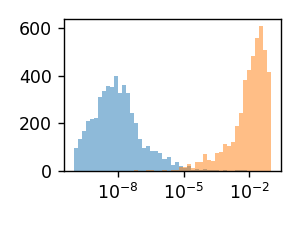

In [94]:
plot_diff(nd_U + nd_U.swapaxes(-1, -2), - S_1_mo)

### B 矩阵

- `B_1` $B_{pq}^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, p, q)$

$$
B_{pq}^{\mathbb{A}, \sigma} = F_{pq}^{\mathbb{A}, \sigma} - S_{pq}^{\mathbb{A}, \sigma} \varepsilon_q^\sigma - \frac{1}{2} \mathtt{Ax}_{pq}^\sigma [S_{ij}^{\sigma'}]
$$

In [95]:
B_1 = gradh.B_1
B_1.shape

(2, 12, 15, 15)

In [96]:
F_1_mo = gradh.F_1_mo
B_1_ = (
    + F_1_mo
    - np.einsum("xApq, xq -> xApq", S_1_mo, e)
    - 0.5 * np.array(Ax0_Core(sa, sa, so, so)((S_1_mo[0, :, so[0], so[0]], S_1_mo[1, :, so[1], so[1]])))
)

In [97]:
np.allclose(B_1_, B_1)

True

### CP-HF 方程验证

$$
- (\varepsilon_a^\sigma - \varepsilon_i^\sigma) U_{ai}^{\mathbb{A}, \sigma} - \mathtt{Ax}_{ai}^\sigma [U_{bj}^{\mathbb{A}, \sigma'}] = B_{ai}^{\mathbb{A}, \sigma}
$$

<IPython.core.display.Javascript object>


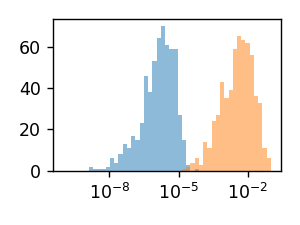

In [98]:
plot_diff(
    - (ev[0][:, None] - eo[0][None, :]) * nd_U[0][:, sv[0], so[0]]
    - Ax0_Core(sv, so, sv, so)((nd_U[0][:, sv[0], so[0]], nd_U[1][:, sv[1], so[1]]))[0]
    ,
    B_1[0][:, sv[0], so[0]]
)

上述等式还可以将 $a, i$ 拓展到 $p \neq q$ 的情形。

### CP-HF 方程求解

在 PySCF 中，求解 Unrestricted CP-HF 方程需要使用的是 `scf.ucphf` 模块。为了讨论问题方便，即使是求取 U 矩阵，我们仍然不会使用到 `solve_withs1` 函数，而实际使用的是 `solve_nos1` 函数。当然，在 PySCF 中，两个函数都会被打包在 `solve` 函数中。

与 Restricted 情形完全不同的是，`ucphf.solve` 在计算过程中的传参方式与 `cphf.solve` 完全不同，尽管两个函数有非常类似的参数签名 (signature)。因此，我们传入的第一个参数不可以再像 Restricted CP-HF 一样使用 `Ax0_Core(sv, so, sv, so)`，而必须要额外定义一个函数 `fx`。传参过程中，U 矩阵会转化为维度 $(\mathbb{A}, n_\mathrm{vir}^\alpha n_\mathrm{occ}^\alpha + n_\mathrm{vir}^\beta n_\mathrm{occ}^\beta)$ 的中间矩阵；这些中间矩阵在下述函数中为 `X` 与 `result` 所指代。

In [99]:
def fx(X):
    prop_dim = X.shape[0]
    X_alpha = X[:, :nocc[0] * nvir[0]].reshape((prop_dim, nvir[0], nocc[0]))
    X_beta = X[:, nocc[0] * nvir[0]:].reshape((prop_dim, nvir[1], nocc[1]))
    Ax = Ax0_Core(sv, so, sv, so, in_cphf=True)((X_alpha, X_beta))
    result = np.concatenate([Ax[0].reshape(prop_dim, -1), Ax[1].reshape(prop_dim, -1)], axis=1)
    return result

- `U_1_vo_` $U_{ai}^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, a, i)$, type: `Tuple[np.ndarray]`

In [100]:
U_1_vo_ = ucphf.solve(fx, e, mo_occ, (B_1[0, :, sv[0], so[0]], B_1[1, :, sv[1], so[1]]), max_cycle=100, tol=1e-10)[0]

<IPython.core.display.Javascript object>


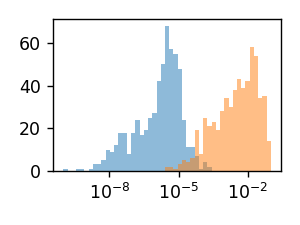

In [101]:
plot_diff(U_1_vo_[0], nd_U[0][:, sv[0], so[0]])

<IPython.core.display.Javascript object>


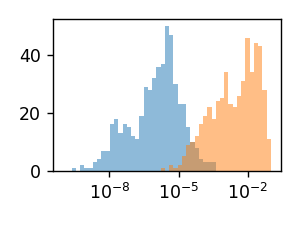

In [102]:
plot_diff(U_1_vo_[1], nd_U[1][:, sv[1], so[1]])

### 完整未“旋转”的 U 矩阵

- `U_1_` $U_{pq}^{\mathbb{A}, \sigma}$, dim: $(\sigma, \mathbb{A}, p, q)$

In [103]:
U_1_ = np.zeros((2, natm * 3, nmo, nmo))
U_1_[0, :, sv[0], so[0]] = U_1_vo_[0]
U_1_[1, :, sv[1], so[1]] = U_1_vo_[1]

$$
U_{ia}^{\mathbb{A}, \sigma} = - S_{ia}^{\mathbb{A}, \sigma} - U_{ai}^{\mathbb{A}, \sigma}
$$

In [104]:
U_1_[0, :, so[0], sv[0]] = - S_1_mo[0, :, so[0], sv[0]] - U_1_vo_[0].swapaxes(-1, -2)
U_1_[1, :, so[1], sv[1]] = - S_1_mo[1, :, so[1], sv[1]] - U_1_vo_[1].swapaxes(-1, -2)

$$
U_{ij}^{\mathbb{A}, \sigma} = - \frac{\mathtt{A}_{ij}^\sigma [U_{ck}^{\mathbb{A}, \sigma'}] + B_{ij}^{\mathbb{A}, \sigma}}{\varepsilon_i^\sigma - \varepsilon_j^\sigma} \quad i \neq j
$$

相同的公式可以用于非占-非占的情形。

In [105]:
Ax_oo = Ax0_Core(so, so, sv, so)(U_1_vo_)
Ax_vv = Ax0_Core(sv, sv, sv, so)(U_1_vo_)

In [106]:
U_1_[0, :, so[0], so[0]] = - (Ax_oo[0] + B_1[0, :, so[0], so[0]]) / (eo[0][:, None] - eo[0][None, :])
U_1_[1, :, so[1], so[1]] = - (Ax_oo[1] + B_1[1, :, so[1], so[1]]) / (eo[1][:, None] - eo[1][None, :])
U_1_[0, :, sv[0], sv[0]] = - (Ax_vv[0] + B_1[0, :, sv[0], sv[0]]) / (ev[0][:, None] - ev[0][None, :])
U_1_[1, :, sv[1], sv[1]] = - (Ax_vv[1] + B_1[1, :, sv[1], sv[1]]) / (ev[1][:, None] - ev[1][None, :])

$$
U_{pp}^{\mathbb{A}, \sigma} = - \frac{1}{2} S_{pp}^{\mathbb{A}, \sigma}
$$

In [107]:
for p in range(nmo):
    U_1_[:, :, p, p] = - S_1_mo[:, :, p, p] / 2

<IPython.core.display.Javascript object>


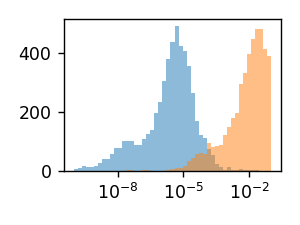

In [108]:
plot_diff(U_1_, nd_U)